In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(os.getcwd(), './data/images_all', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

In [5]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: '1.0' if c_label in finding else '0')

In [6]:
train_val_list = pd.read_fwf('./data/train_val_list.txt', header=None)
train_val_list = train_val_list.squeeze()
train_df = all_xray_df.loc[all_xray_df['Image Index'].isin(train_val_list)]
test_list = pd.read_fwf('./data/test_list.txt', header=None)
test_list = test_list.squeeze()
test_df = all_xray_df.loc[all_xray_df['Image Index'].isin(test_list)]

In [7]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15,
                              brightness_range=[-0.2,0.2])

Using TensorFlow backend.


In [8]:
all_xray_df['path'] = all_xray_df['Image Index'].map(lambda x: './data/images_all/'+x)

In [17]:
columns=['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis','Hernia','Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']
CLASS_MODE = 'raw'
Y_COL = columns
DIRESTORY = None
X_COL = 'path'
CLASSES = all_labels
COLOR_MODE = 'rgb'

train_gen=core_idg.flow_from_dataframe(
                        dataframe=train_df,
                        directory=DIRESTORY,
                        x_col=X_COL,
                        y_col=Y_COL,
                        batch_size=4,
                        color_mode = COLOR_MODE,
                        class_mode=CLASS_MODE,
                        target_size=IMG_SIZE)

valid_gen=core_idg.flow_from_dataframe(
                        dataframe=test_df,
                        directory=DIRESTORY,
                        x_col=X_COL,
                        y_col=Y_COL,
                        batch_size=12,
                        color_mode = COLOR_MODE,
                        class_mode=CLASS_MODE,
                        target_size=IMG_SIZE)

Found 86524 validated image filenames.
Found 25596 validated image filenames.


In [18]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('|', ','))

In [10]:
import keras.backend as K
from sklearn.preprocessing import MultiLabelBinarizer


classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation',
           'Edema', 'Effusion', 'Emphysema', 
           'Fibrosis', "Infiltration", 'Hernia', 
           "Mass", 'Nodule', 'Pleural_Thickening', 
           'Pneumonia', 'Pneumothorax']

encoder = MultiLabelBinarizer(classes=classes)
labels = encoder.fit_transform([c.split(",") for c in list(all_xray_df["Finding Labels"])])

def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights


class_weights = calculating_class_weights(labels)

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

/home/dymkiewi/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) [''] will be ignored
  .format(sorted(unknown, key=str)))


In [12]:
from keras_radam import RAdam
from keras_lookahead import Lookahead


#Lookahead(RAdam())
# ranger_optimizer = Lookahead(RAdam())
ranger_optimizer = 'adam'

In [25]:
# from sklearn.metrics import roc_auc_score

# def auc_score(y_true, y_pred):
#     return roc_auc_score(y_true, y_pred)

In [13]:
from efficientnet.keras import EfficientNetB6
import tensorflow as tf

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.metrics import AUC


base_model = EfficientNetB6(input_shape =  (256,256,3), 
                                 include_top = False, weights = 'imagenet')
multi_disease_model = Sequential()
multi_disease_model.add(base_model)

# multi_disease_model.add(MaxPooling2D(pool_size=2))
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dense(128))
multi_disease_model.add(BatchNormalization())
multi_disease_model.add(Activation('relu'))
multi_disease_model.add(Dense(128))
multi_disease_model.add(Activation('relu'))

multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))

multi_disease_model.compile(optimizer = ranger_optimizer,
                            loss = 'binary_crossentropy'
#                             loss = get_weighted_loss(class_weights)
                            ,metrics =[AUC(name='auc')])

# multi_disease_model.summary()

In [15]:
multi_disease_model.load_weights('./oficial_split_imagenet_b6_adam_binary_crossentropy_.hdf5')

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_.hdf5".format('oficial_split_imagenet_b6_adam_binary_crossentropy')

checkpoint = ModelCheckpoint(weight_path, monitor='val_auc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

early = EarlyStopping(monitor="val_auc", 
                      mode="max", 
                      patience=10,
                     verbose = 1)
callbacks_list = [checkpoint, early]

In [ ]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=10000,
                                  validation_data = valid_gen, 
#                                   validation_steps = 200,
                                  epochs = 30, 
                                  callbacks = callbacks_list)

Epoch 1/30
10000/10000 [==============================] - 4786s 479ms/step - loss: 0.1637 - auc: 0.7491 - val_loss: 0.1790 - val_auc: 0.7236

Epoch 00001: val_auc improved from -inf to 0.72357, saving model to oficial_split_imagenet_b6_adam_binary_crossentropy_.hdf5
Epoch 2/30
10000/10000 [==============================] - 4708s 471ms/step - loss: 0.1648 - auc: 0.7493 - val_loss: 0.6236 - val_auc: 0.6415

Epoch 00002: val_auc did not improve from 0.72357
Epoch 3/30
10000/10000 [==============================] - 4710s 471ms/step - loss: 0.1640 - auc: 0.7486 - val_loss: 0.3041 - val_auc: 0.7244

Epoch 00003: val_auc improved from 0.72357 to 0.72437, saving model to oficial_split_imagenet_b6_adam_binary_crossentropy_.hdf5
Epoch 4/30
10000/10000 [==============================] - 4707s 471ms/step - loss: 0.1646 - auc: 0.7525 - val_loss: 0.2273 - val_auc: 0.7227

Epoch 00004: val_auc did not improve from 0.72437
Epoch 5/30
10000/10000 [==============================] - 4715s 471ms/step - lo

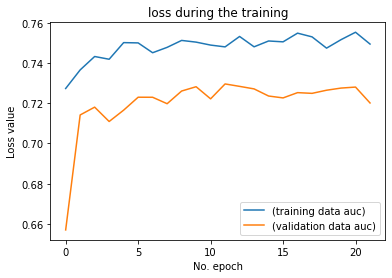

In [22]:
# plt.plot(history.history['loss'], label='(training data loss)')
# plt.plot(history.history['val_loss'], label='(validation data loss)')

plt.plot(history.history['auc'], label='(training data auc)')
plt.plot(history.history['val_auc'], label='(validation data auc)')

plt.title('auc during the training')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

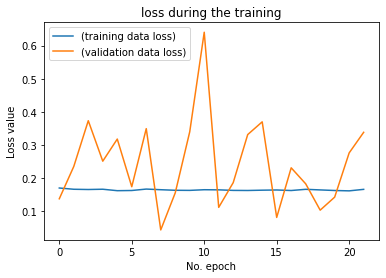

In [20]:
plt.plot(history.history['loss'], label='(training data loss)')
plt.plot(history.history['val_loss'], label='(validation data loss)')

plt.title('loss during the training')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
test_X, test_Y = next(core_idg.flow_from_dataframe(
                        dataframe=valid_df,
                        directory=DIRESTORY,
                        x_col=X_COL,
                        y_col=Y_COL,
                        batch_size=25596,
                        color_mode = COLOR_MODE,
                        class_mode=CLASS_MODE,
                        target_size=IMG_SIZE))

In [ ]:
pred_Y = multi_disease_model.predict(test_X, verbose = True)
test_Y = test_Y.astype(np.float)
roc_auc_score(test_Y, pred_Y)

In [ ]:
from sklearn.metrics import roc_curve, auc
avg = []
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.4f)'  % (c_label, auc(fpr, tpr)))
    avg.append(auc(fpr, tpr).astype(np.float))
    
print(sum(avg) / len(avg))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')